In [49]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd 
import numpy as np
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.clustering import TimeSeriesKMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sbn 
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import statsmodels.api as sm
from patsy import dmatrices

import sys
sys.path.append('./src/')
%aimport lib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
class EFM_neratinib: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_EFM192A_data_11-1-21/']
        self.drug = ['neratinib']
        self.resample_sz = [125]
        self.nclus = [10]
        self.sensitive_line = ['WT']
        self.resistant_line = ['T798I']
        self.burnin = [2]

class EFM_trastuzumab: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_EFM192A_data_11-1-21/']
        self.drug = ['trastuzumab']
        self.resample_sz = [125]
        self.nclus = [15]
        self.sensitive_line = ['WT']
        self.resistant_line = ['ND611']
        self.burnin = [2]

class SKB_neratinib: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_SKBR3_data_6-7-21/']
        self.drug = ['neratinib']
        self.resample_sz = [125]
        self.nclus = [15]
        self.sensitive_line = ['WT']
        self.resistant_line = ['T798I']
        self.burnin = [2]

class SKB_trastuzumab: 
    def __init__(self): 
        self.load = ['normalized']
        self.data = ['./data/HER2_SKBR3_data_6-7-21/']
        self.drug = ['trastuzumab']
        self.resample_sz = [125]
        self.nclus = [10]
        self.sensitive_line = ['WT']
        self.resistant_line = ['ND611']
        self.burnin = [2]


In [85]:
#args = SKB_neratinib()

args = SKB_trastuzumab()
#args = EFM_neratinib()
#args = EFM_trastuzumab()

In [86]:
data, clover_sel, mscarl_sel = lib.load_data(args)
data.head()


loading data...
# of datasets to load: 13


,track_index,0_x,15_x,30_x,45_x,60_x,75_x,90_x,105_x,120_x,...,2805_y,2820_y,2835_y,2850_y,2865_y,2880_y,2895_y,drug,cell_line,mutant
0,79_1000188375_skbr3_erk_akt__wt_untreated,0.240343,0.305148,0.359093,0.377887,0.430450,0.472083,0.470617,0.594090,0.594985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
1,3_1000012495_skbr3_erk_akt__wt_untreated,0.258892,0.323697,0.405762,0.422704,0.424451,0.429620,0.416867,0.365984,0.361178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
2,79_1000188229_skbr3_erk_akt__wt_untreated,0.360215,0.425021,0.478966,0.501633,0.601752,0.611347,0.571254,0.543516,0.737053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
3,1_1000003862_skbr3_erk_akt__wt_untreated,0.724460,0.693145,0.805601,0.818410,0.727231,0.674704,0.707653,0.679908,0.713188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
4,3_1000012346_skbr3_erk_akt__wt_untreated,0.526140,0.678670,0.609742,0.562597,0.607743,0.511163,0.552604,0.780575,0.673951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT


In [87]:
data.cell_line.unique()

array(['SKBR3'], dtype=object)

In [88]:
data[lambda x: (x.dataset.str.upper() == 'H210205_SET1_2') ] # 'H210514_SET2')] #

,track_index,0_x,15_x,30_x,45_x,60_x,75_x,90_x,105_x,120_x,...,2805_y,2820_y,2835_y,2850_y,2865_y,2880_y,2895_y,drug,cell_line,mutant
0,3_1000011860_skbr3_erk_akt__WT_untreated,0.836900,0.838897,0.557456,0.852664,1.137005,0.798656,0.696818,0.596282,0.495039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
1,79_1000288819_skbr3_erk_akt__WT_untreated,0.615120,0.775863,0.840381,0.828898,0.797149,0.827444,0.779779,0.848228,0.868804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
2,78_1000285319_skbr3_erk_akt__WT_untreated,0.790633,0.865733,0.793790,0.890870,0.870234,0.917848,0.700682,1.004571,0.972406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
3,78_1000282488_skbr3_erk_akt__WT_untreated,0.919838,0.836807,0.853458,0.712794,0.662686,0.630794,0.635830,0.723558,0.749466,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
4,1_1000002701_skbr3_erk_akt__WT_untreated,0.822612,0.834595,0.920568,0.968030,0.896872,0.906976,0.933929,0.925297,0.913278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,untreated,SKBR3,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3121,202_1000704868_skbr3_erk_akt__I767M_10ug_ml_tr...,0.626057,0.660615,0.677543,0.649554,0.696676,0.642291,0.617692,0.621422,0.575283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trastuzumab,SKBR3,I767M
3122,199_1000698160_skbr3_erk_akt__I767M_10ug_ml_tr...,0.142613,0.177779,0.217564,0.656586,0.385992,0.618144,0.731663,0.348799,0.521888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trastuzumab,SKBR3,I767M
3123,198_1000696387_skbr3_erk_akt__I767M_10ug_ml_tr...,0.206733,0.278835,0.305447,0.306494,0.317450,0.335671,0.314507,0.288211,0.297530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trastuzumab,SKBR3,I767M
3124,200_1000700474_skbr3_erk_akt__I767M_10ug_ml_tr...,0.427868,0.431335,0.475250,0.511791,0.564157,0.538850,0.520495,0.501383,0.503413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trastuzumab,SKBR3,I767M


In [76]:
data.dataset

0       H210423_Set1
1       H210423_Set1
2       H210423_Set1
3       H210423_Set1
4       H210423_Set1
            ...     
1623    H210326_Set1
1624    H210326_Set1
1625    H210326_Set1
1626    H210326_Set1
1627    H210326_Set1
Name: dataset, Length: 34619, dtype: object

In [77]:
data[lambda x: x.dataset.str.upper() == 'H210514_SET1']

,track_index,0_x,15_x,30_x,45_x,60_x,75_x,90_x,105_x,120_x,...,2805_y,2820_y,2835_y,2850_y,2865_y,2880_y,2895_y,drug,cell_line,mutant


In [22]:
data = lib.filter_data(args, data, clover_sel, mscarl_sel)


filtering to drug and removing NAs...
drug id: trastuzumab
Data shape (untreated + drug): (20892, 398)
length of time series BEFORE removing time points with NA 150
length of time series AFTER removing time points with NA 135


In [23]:
# eda 
data.dataset.unique()

array(['H210423_Set1', 'H210219_Set1', 'H210326_Set2', 'H210401_Set1',
       'H210205_Set2_2', 'H210205_Set1_2', 'H210409_Set1', 'H210212_Set1',
       'H210401_Set2', 'H210409_Set2', 'H210219_Set2', 'H210212_Set2',
       'H210326_Set1'], dtype=object)

In [24]:
data[lambda x: x.mutant.isin(['T798I', 'WT', 'ND611'])].groupby(['dataset', 'mutant']).count()[['track_index']]

track_index
dataset        mutant             
H210205_Set1_2 ND611           112
               T798I           148
               WT              209
H210205_Set2_2 ND611           159
               T798I           239
               WT              393
H210212_Set1   ND611           167
               T798I           239
               WT              186
H210212_Set2   ND611           148
               T798I           185
               WT              192
H210219_Set1   ND611           249
               T798I           249
               WT              284
H210219_Set2   ND611           164
               T798I           228
               WT              322
H210326_Set1   ND611            54
               T798I           114
               WT              155
H210326_Set2   ND611            43
               T798I           133
               WT              177
H210401_Set1   ND611            97
               T798I           159
               WT              195
H210401_Set2   ND611            85
               T798I           164
               WT              219
H210409_Set1   ND611            89
               T798I           177
               WT              208
H210409_Set2   ND611            84
               T798I           133
               WT              234
H210423_Set1   ND611            69
               T798I           176
               WT              145

In [25]:
data.mutant.unique()

array(['WT', 'T798I', 'ND611', 'P579L', 'R288Q', 'A37T', 'D933Y', 'E405D',
       'F976L', 'L755S', 'S609C', 'T479M', 'W906C', 'Y64F', 'D277H',
       'D638H', 'M889I', 'N488S', 'Q1206K', 'W825', 'A1039T', 'E975Q',
       'S310F', 'R34W', 'R929WL', 'S963', 'V797A', 'Y722V773INSRDGE',
       'L1197F', 'ND648', 'A355QFS76', 'D639E', 'Y835F', 'V842I', 'R678Q',
       'V424I', 'S310Y', 'T306M', 'L313V', 'T733I', 'L755T759DEL',
       'I767M', 'N427K', 'P232S', 'R190Q', 'A1160V', 'T297I', 'T862S',
       'V697L', 'D769Y', 'E717K', 'E744D', 'G621AFS31', 'I435L', 'I886M',
       'R1153L', 'Y1127A1129DEL', 'R897G', 'P523S', 'D769N',
       'E770A771INSGIRD', 'D873G', 'G1055C', 'G778S779INSLPS', 'H470Q',
       'H878Y', 'L662V', 'M833I', 'L43V', 'P416T', 'P702L', 'R203P',
       'R340G', 'R456C', 'R47C', 'L785F', 'L869R', 'P122L', 'S305C',
       'W482GFS74', 'E939G', 'G727A'], dtype=object)

In [26]:
# BURNIN

In [27]:
# add burnin 
clover_sel = clover_sel[args.burnin[0]:]
mscarl_sel = mscarl_sel[args.burnin[0]:]

In [28]:
X_train = lib.resample(args, data, clover_sel, mscarl_sel)



resampling time series...
Training data shape BEFORE resampling: (20892, 148, 2)
Training data shape AFTER resampling: (20892, 125, 2)



performing time-series kmeans clustering...

7.065 --> 5.250 --> 5.133 --> 5.081 --> 5.053 --> 5.037 --> 5.027 --> 5.020 --> 5.014 --> 5.010 --> 5.007 --> 5.005 --> 5.004 --> 5.002 --> 5.001 --> 5.000 --> 4.999 --> 4.998 --> 4.998 --> 4.997 --> 4.996 --> 4.995 --> 4.995 --> 4.994 --> 4.994 --> 4.994 --> 4.993 --> 4.993 --> 4.993 --> 4.993 --> 4.992 --> 4.992 --> 4.992 --> 4.992 --> 4.991 --> 4.991 --> 4.991 --> 4.991 --> 4.991 --> 4.991 --> 4.990 --> 4.990 --> 4.990 --> 4.989 --> 4.989 --> 4.989 --> 4.989 --> 4.988 --> 4.988 --> 4.988 --> 
plotting...


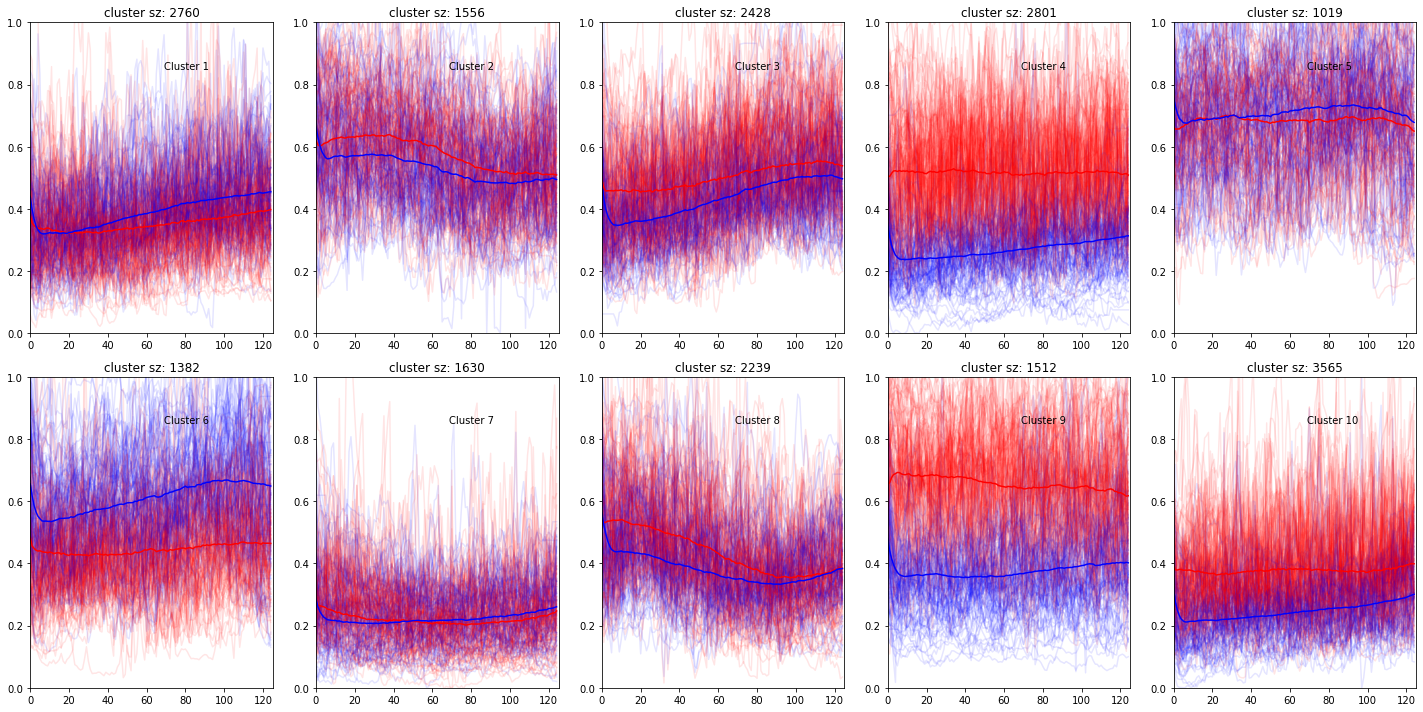

In [29]:
y_pred, km = lib.fit_kmeans(args, X_train, save=None)

In [30]:
cm, lb = lib.calc_cluster_proportions(args, y_pred, data)


quantifying experiment by cluster proportions...


<Figure size 504x504 with 0 Axes>

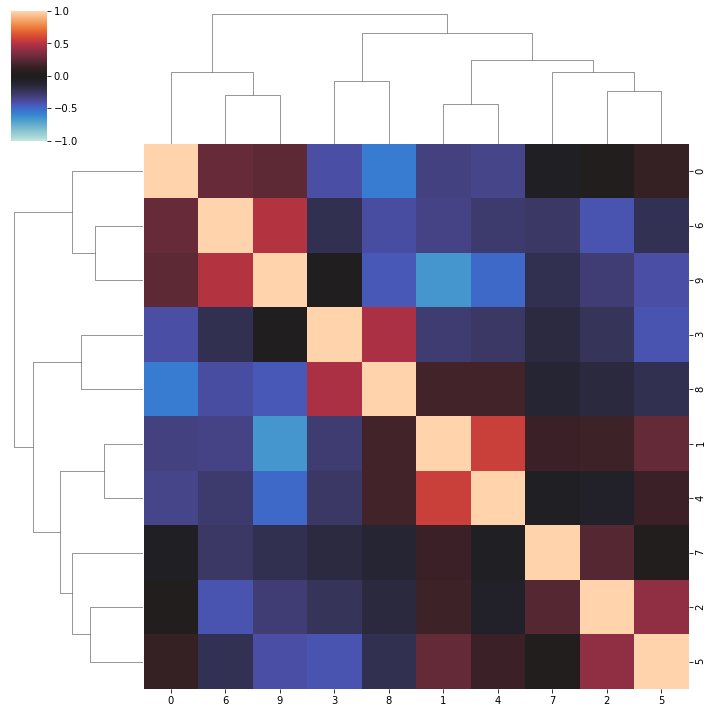

In [31]:
lib.plot_cluster_corr(cm, save=None)

In [32]:
lb.classes_

array(['skbr3_erk_akt__A355QFS76_10ug_ml_trastuzumab--H210205_Set2_2',
       'skbr3_erk_akt__A355QFS76_untreated--H210205_Set2_2',
       'skbr3_erk_akt__D277H_10ug_ml_trastuzumab--H210219_Set1',
       'skbr3_erk_akt__D277H_untreated--H210219_Set1',
       'skbr3_erk_akt__D638H_10ug_ml_trastuzumab--H210219_Set1',
       'skbr3_erk_akt__D638H_untreated--H210219_Set1',
       'skbr3_erk_akt__D639E_10ug_ml_trastuzumab--H210205_Set2_2',
       'skbr3_erk_akt__D639E_untreated--H210205_Set2_2',
       'skbr3_erk_akt__D769Y_10ug_ml_trastuzumab--H210212_Set1',
       'skbr3_erk_akt__D769Y_untreated--H210212_Set1',
       'skbr3_erk_akt__D873G_10ug_ml_trastuzumab--H210219_Set2',
       'skbr3_erk_akt__D873G_untreated--H210219_Set2',
       'skbr3_erk_akt__E717K_10ug_ml_trastuzumab--H210212_Set1',
       'skbr3_erk_akt__E717K_untreated--H210212_Set1',
       'skbr3_erk_akt__E744D_10ug_ml_trastuzumab--H210212_Set1',
       'skbr3_erk_akt__E744D_untreated--H210212_Set1',
       'skbr3_erk_akt__G


performing dim. reduction (pca)...
PCA explained variance ratio: [0.37800238 0.24340491]
PC shape: (252, 2)


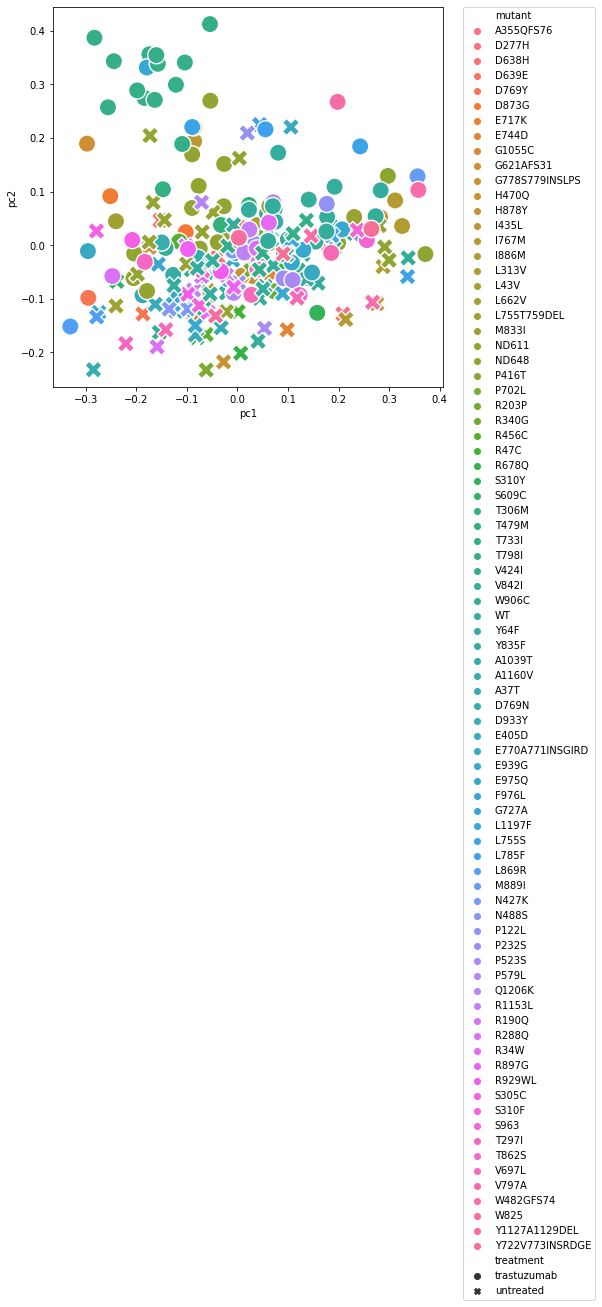

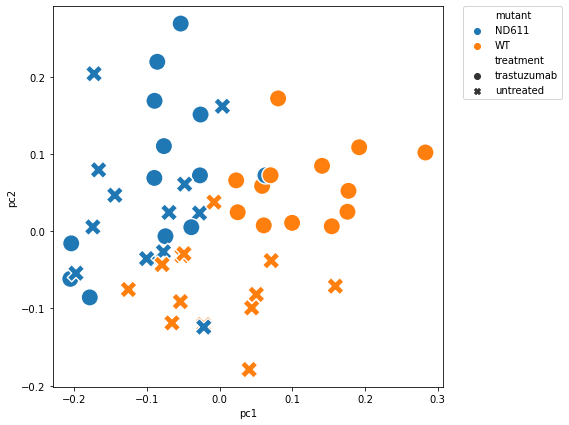

In [33]:
pca, res, _sens, _res, _drug = lib.dimensionality_reduction(args, cm, lb, save=None)

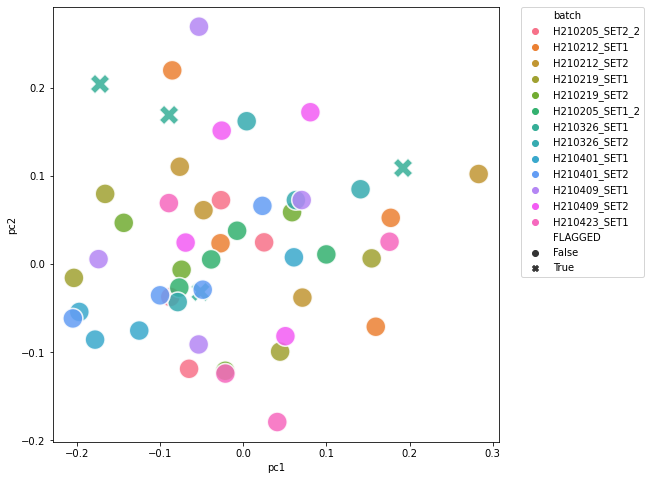

,batch,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id
0,H210205_SET1_2,0.012914,0.807358,-0.010442,0.782027,dummy_id
1,H210205_SET2_2,-0.020038,0.705337,-0.032031,0.398071,dummy_id
2,H210212_SET1,0.074782,0.163225,0.038905,0.305769,dummy_id
3,H210212_SET2,0.076316,0.154983,0.041653,0.273343,dummy_id
4,H210219_SET1,-0.024139,0.648870,-0.024513,0.516977,dummy_id


In [159]:
batch_res = lib.get_batch_effects(args, res, 'dummy_id', save=None)
batch_res.head()

In [156]:
batch_res

,batch,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id
0,H210205_SET1_2,0.012914,0.807358,-0.010442,0.782027,dummy_id
1,H210205_SET2_2,-0.020038,0.705337,-0.032031,0.398071,dummy_id
2,H210212_SET1,0.074782,0.163225,0.038905,0.305769,dummy_id
3,H210212_SET2,0.076316,0.154983,0.041653,0.273343,dummy_id
4,H210219_SET1,-0.024139,0.648870,-0.024513,0.516977,dummy_id
5,H210219_SET2,-0.026593,0.616038,-0.022754,0.547356,dummy_id
6,H210326_SET1,-0.011578,0.826944,0.095433,0.015053,dummy_id
7,H210326_SET2,0.051152,0.336915,0.051819,0.174815,dummy_id
8,H210401_SET1,-0.091390,0.090376,-0.069246,0.072431,dummy_id
9,H210401_SET2,-0.064131,0.230227,-0.032325,0.393783,dummy_id


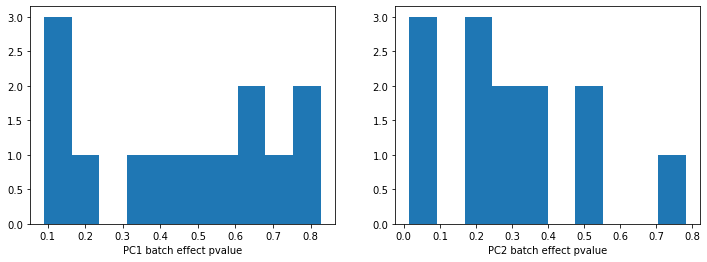

In [144]:
f,axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(batch_res.pc1_pval)
axes[0].set_xlabel('PC1 batch effect pvalue')
axes[1].hist(batch_res.pc2_pval)
axes[1].set_xlabel('PC2 batch effect pvalue')
plt.show()


training classifier...
sensitive line: WT
resistant line: ND611
drug: trastuzumab
drug + WT df size:  (26, 5)
X train shape: (26, 2)
# neg class (resistant): 13
# pos class (sensitive): 13


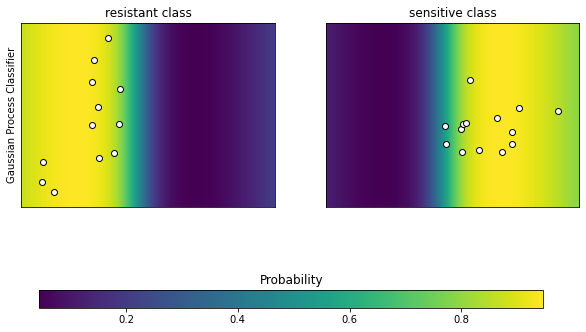

In [145]:
model, accuracy = lib.train_classifier(res, _sens, _res, _drug, save=None)

In [18]:
prob_res = lib.predict_new(args, res, model)
prob_res.head()


predicting unlabeled sensitivities...


,pc1,pc2,treatment,mutant,prob_res,prob_sens,call
0,0.156621,0.016438,trastuzumab,A355QFS76,0.044391,0.955609,sens
1,0.062051,-0.027993,trastuzumab,D277H,0.089424,0.910576,sens
2,-0.012147,0.037398,trastuzumab,D638H,0.610790,0.389210,res
3,-0.031162,0.047932,trastuzumab,D639E,0.784760,0.215240,res
4,-0.304365,-0.110301,trastuzumab,D769Y,0.729331,0.270669,res


In [19]:
prob_res.sort_values('prob_res', ascending=False).head()

,pc1,pc2,treatment,mutant,prob_res,prob_sens,call
111,-0.086512,0.172236,trastuzumab,T798I,0.959633,0.040367,res
23,-0.104179,0.098939,trastuzumab,ND611,0.958645,0.041355,res
40,-0.132740,0.113491,trastuzumab,T733I,0.955890,0.044110,res
81,-0.066846,0.167651,trastuzumab,ND611,0.955095,0.044905,res
14,-0.062497,0.207244,trastuzumab,I767M,0.951172,0.048828,res


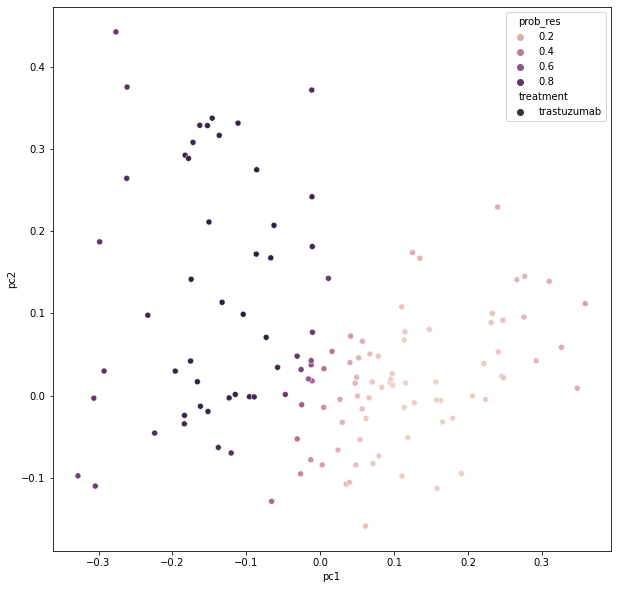

In [20]:
plt.figure(figsize=(10,10))
sbn.scatterplot(x='pc1', y='pc2', hue='prob_res', style='treatment', data=prob_res)
plt.show()